In [1]:
# import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import palettable
import pickle

import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [2]:
# read data
df = pd.read_csv('heart_2020_cleaned.csv')

## 1. Undersample imbalanced dataset

The distribution of dependent variable is highly imbalanced. The data discrimination may cause potential problems such as biased prediction which leads to a high accuracy but a relatively low AUC. Thus, for the purpose of building better models, I undersampled the data points for people who do not have a heart disease.

In [3]:
# dependent variable distribution
df['HeartDisease'].value_counts(dropna=False)

No     292422
Yes     27373
Name: HeartDisease, dtype: int64

In [4]:
# undersample data points
df_yes = df[df['HeartDisease'] == 'Yes']
df_no = df[df['HeartDisease'] == 'No']
count_no, count_yes = df['HeartDisease'].value_counts()
df_no_under = df_no.sample(count_yes)
df_under = pd.concat([df_no_under, df_yes], axis=0)
df = df_under

In [5]:
# dependent variable distribution
df['HeartDisease'].value_counts(dropna=False)

No     27373
Yes    27373
Name: HeartDisease, dtype: int64

After undersampling, I managed to get a balanced dataset. In the adjusted dataset with 54,546 records, the number of respondents with or without heart disease is both 27,373. Respondents with heart disease account for 50% in the overall.

## 2. Feature Engineering

From the correlation matrix, there are no apparent correlations among numerical features, which indicates that changes in one numerical feature would not have significant effects on one another. Hence, there is no need to delete any of the numerical features.

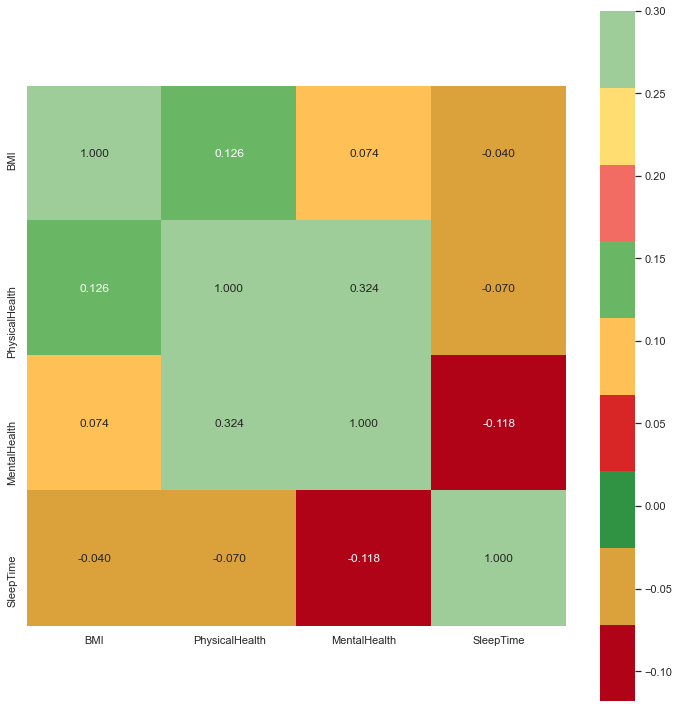

In [6]:
# draw a correlation heatmap of numerical features
corr = df.corr()
f, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr, vmax=0.3, annot=True, fmt='.3f', square=True, cmap=palettable.tableau.TrafficLight_9.mpl_colors)
plt.tight_layout()
plt.show()

## 3. Recode Categorical Features

The data should be transformed based on the feature types. Dependent variable HeartDisease was transformed with value 0 meaning negative and 1 meaning positive. For categorical features, binary encoding was used for features including Smoking, AlcoholDrinking, Stroke, DiffWalking, Sex, Diabetic, Physical Activity, Asthma, KidneyDisease and SkinCancer; ordinal encoding was used for features AgeCategory and GenHealth; one hot encoding was used for features Race and Diabetic. 

In [7]:
# make a copy
copy = df

In [8]:
# transform dependent variable
copy['HeartDisease'] = copy['HeartDisease'].replace({'Yes':1,'No':0})

In [9]:
# transform binary categorical features
bi = ['Smoking',
      'AlcoholDrinking',
      'Stroke',
      'Asthma', 
      'DiffWalking',
      'PhysicalActivity',
      'KidneyDisease',
      'SkinCancer']
for val in bi:
    copy[val] = copy[val].replace({'Yes':1,'No':0})

In [10]:
# transform ordinal categorical features
age_encoder = ce.OrdinalEncoder(cols=['AgeCategory'],
                                return_df=True,
                                mapping=[{'col':'AgeCategory',
                                          'mapping':{'18-24':0,'25-29':1,
                                                     '30-34':2,'35-39':3,
                                                     '40-44':4,'45-49':5,
                                                     '50-54':6,'55-59':7,
                                                     '60-64':8,'65-69':9,
                                                     '70-74':10,'75-79':11,
                                                     '80 or older':12}}])
health_encoder = ce.OrdinalEncoder(cols=['GenHealth'], 
                                   return_df=True,
                                   mapping=[{'col':'GenHealth',
                                             'mapping':{'Poor':0,'Fair':1,
                                                        'Good':2,'Very good':3,
                                                        'Excellent':4}}])
copy = age_encoder.fit_transform(copy)
copy = health_encoder.fit_transform(copy)

In [11]:
# tranform nominal categorical features
copy = pd.get_dummies(copy)

## 4. Split Dataset

I split the dataset into training (70%) and testing (30%) for further machine learning model building, selection and application. 

In [12]:
# split into training and test set
X_train, X_test, y_train, y_test = train_test_split(copy.drop('HeartDisease', axis=1), copy.HeartDisease, 
                                                    test_size=0.3, random_state=123)

In [13]:
# observe training and test set size
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(38322, 26)
(16424, 26)
(38322,)
(16424,)


## 5. Standardize numerical features

Eventually, the numerical data entries were normalized using the package ‘StandardScaler’ from sklearn and I ensured that normalization of test set utilized all the statistical characteristics from the training set.

In [14]:
# transform numerical features in training set
ss = StandardScaler()
for cols in ['BMI','PhysicalHealth','MentalHealth','SleepTime']:
    X_train[cols] = ss.fit_transform(X_train[[cols]])
    X_test[cols] = ss.transform(X_test[[cols]])

## 6. Save training and test data

In [15]:
# save training and test data to csv files
X_train.to_csv('X_train.csv')
y_train.to_csv('y_train.csv')
X_test.to_csv('X_test.csv')
y_test.to_csv('y_test.csv')